# [NTDS'19] assignment 2: learning with graphs
[ntds'19]: https://github.com/mdeff/ntds_2019

[Clément Vignac](https://people.epfl.ch/clement.vignac), [EPFL LTS4](https://lts4.epfl.ch) and
[Guillermo Ortiz Jiménez](https://gortizji.github.io), [EPFL LTS4](https://lts4.epfl.ch).

## Students

* Team: `<5>`
* Students: `<STUDENT`> (for the indivudual submission) or `<Alice Bizeul, Gaia Caparelli, Hugues Vincent, Antoine Spahr>` (for the team submission)

## Rules

Grading:
* The first deadline is for individual submissions. The second deadline is for the team submission.
* All team members will receive the same grade based on the team solution submitted on the second deadline.
* As a fallback, a team can ask for individual grading. In that case, solutions submitted on the first deadline are graded.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.

Submission:
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter.

## Objective

In this assignment you will experiment with the main concepts of spectral graph theory, as well as familizarize yourself with the main data science techniques for network data.

The assignment is made of three parts:
1. [Spectral Graph Theory](#sgt)
1. [Regularization on graphs with Graph Signal Processing](#gsp)
1. [Machine Learning on Graphs](#ml)

<a id='sgt'></a>
## Part I: Spectral Graph Theory
### Eigenvectors and eigenvalues

We will start by reviewing some of the main concepts in spectral graph theory and see some of its applications to dimensionality reduction and data clustering. To illustrate the main concepts we will use the standard two moon dataset.

In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

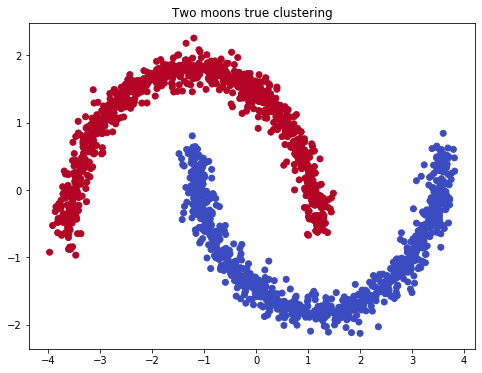

In [2]:
from pygsp.graphs import TwoMoons

G = TwoMoons(moontype='synthesized', N=2000)
X = G.coords
Y = G.labels.astype(int)

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(X[:, 0], X[:, 1], c=Y, cmap='coolwarm')
ax.set_title('Two moons true clustering')
plt.show()

#### Question 1: Graph construction
Build a similarity graph using the euclidean distance between data points.   
**Note:** Use an RBF kernel to set the edge weights $w_{ij}=\exp(-||x_i- x_j||_2^2 / ~ 2 \sigma^2)$ of your adjacency and threshold the ones with the smallest magnitude.

In [3]:
def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
    """ X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    # compute distance
    Dist = squareform(pdist(X))
    # compute kernel
    A = np.exp(-Dist**2 / (2*sigma**2)) 
    # Thresholding 
    A[np.where(A < epsilon)] = 0 
    # diagonal to zero
    np.fill_diagonal(A,0)
    
    return A

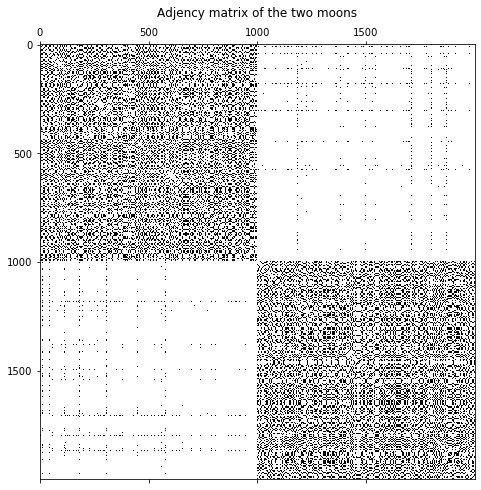

In [4]:
adjacency = epsilon_similarity_graph(X, sigma=1, epsilon=0.4)
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.spy(adjacency)
ax.set_title('Adjency matrix of the two moons')
plt.show()

How do you choose `sigma`?

*Your answer here* 
<br> Sigma is an hyperparameter to be tuned (the higher the sigma the denser the adjacency matrix). It controls the width of he kernel. High value allows point further appart to be connected. 

How do you choose the threshold `epsilon`?

*Your answer here* 
<br> Same for the threshold epsilon, it is a hyperparameter to be tuned (a high epsilon will produce a sparser adjacency matrix). It controls the sparstity of the of the adjacency matrix. 

#### Question 2: Laplacian
Build the combinatorial and normalized graph laplacians for this dataset.

In [5]:
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    # degrees
    I = np.identity(adjacency.shape[0])
    degree = np.sum(adjacency, axis=1)
    # Compute laplacian
    D = I.copy()
    np.fill_diagonal(D, degree)
    L = D - adjacency
    # normalized if requested 
    if normalize:
        D12 = np.where(D > 0, np.power(D, -0.5, where=D>0), 0)
        L = D12 @ L @ D12
        
    return L

In [6]:
laplacian_comb = compute_laplacian(adjacency, normalize=False)
laplacian_norm = compute_laplacian(adjacency, normalize=True)

#### Question 3: Eigendecomposition

For both Laplacian matrices, compute the eigendecomposition $L = U^\top \Lambda U$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues. Make sure that the eigenvalues are ordered, i.e., $\lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$. 

Justify your choice of a solver for the eigendecomposition.

*Your answer here*
<br> We have to justify what we would choose between combinatorial and normalized? For the eigendecomposition? 
<br> In the case of the combinatorial laplacian, L is symetric. The normalization makes the eigenvalues between 0 and 2.

The eigh numpy function computes the eigendecomposition on Hermitian matrix. It takes advantage of the symmetry of the matrix to compute more efficiently the decomposition. In our case the matrix is real, hence hermitian if it is symmetric. A condition was added to verify the symmetry of the matrix, if the condition is verified, the eigh function is used otherwise the eig function is called.

In [7]:
def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    # compute the eigenvalues and eigenvectors
    if np.allclose(laplacian, laplacian.T, 1e-12):
        lamb, U = np.linalg.eigh(laplacian)
    else:
        lamb, U = np.linalg.eig(laplacian)
        #sort them
        idx = np.argsort(lamb, axis=0)
        lamb = lamb[idx]
        U = U[:,idx]
    
    return lamb, U

In [8]:
lamb_comb, U_comb = spectral_decomposition(laplacian_comb)
lamb_norm, U_norm = spectral_decomposition(laplacian_norm)

In [9]:
# Just to visualize
print('min combinatorial laplacian lambdas', min(lamb_comb))
print('max combinatorial laplacian lambdas', max(lamb_comb))
print('min normalized laplacian lambdas', min(lamb_norm))
print('max normalized laplacian lambdas', max(lamb_norm))

# Don't we need to have the first eigenvalue be = 0??

min combinatorial laplacian lambdas 3.3673535667869046e-14
max combinatorial laplacian lambdas 319.2363179788614
min normalized laplacian lambdas -3.6533131504263776e-16
max normalized laplacian lambdas 1.09631459033386


#### Question 4: Interpretation
We plot the sorted eigenvalues as a function of their index:

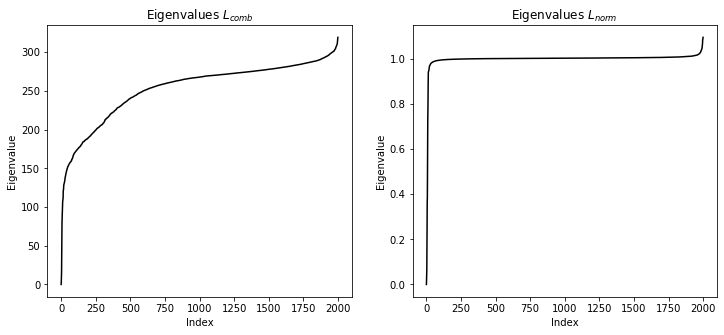

In [10]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(lamb_comb, color='black')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{comb}$')
plt.subplot(122)
plt.plot(lamb_norm, color='black')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')
plt.show()

In [11]:
print('Eigenvector 0 for the combinatorial laplacian matrix', U_comb[:,0])
print('Eigenvector 0 for the normalized laplacian matrix', U_norm[:,0])

Eigenvector 0 for the combinatorial laplacian matrix [0.02236068 0.02236068 0.02236068 ... 0.02236068 0.02236068 0.02236068]
Eigenvector 0 for the normalized laplacian matrix [-0.02128743 -0.02141101 -0.02295598 ... -0.02119281 -0.01760526
 -0.02446971]


What is the lowest eigenvalue $\lambda_0$ and the corresponding eigenvector $u_0$? Answer for both Laplacian matrices.

*Your answer here* 
<br> The lowest eigenvalue is considered as zero for both Laplacian matrices. The corresponding eigenvector is shown above, for the combinatorial laplacian the first eigenvector is equal to -1 * 1/sqrt(N) (regarding the constant -1 : all multiplication of an eigenvector by a constant remains an eigenvector) and for the normalized laplacian it is equal to D^1/2/norm(D^1/2), so not constant as shows by our results.

When filtering a signal or computing polynomials, which Laplacian provides the best numerical stability? Justify your answer.

The numerical stability can be understood as the smoothness of the sorted eigenvalues. As shown above, the derivative of the curve for the combinatorial laplacian is higher than the normalized one indicating a higher variation in eigenvalues. The distribution of normalized eigenvalues are more uniform than for the combinatorial laplacian.


#### Question 5: Connected components
The eigendecomposition provides an easy way to compute the number of connected components in the graph. Fill the following function:

In [12]:
def compute_number_connected_components(lamb: np.array, threshold: float):
    """ lamb: array of eigenvalues of a Laplacian
        Return:
        n_components (int): number of connected components.
    """
    # Nbr of connected component is the number of zero eigenvalues
    thresholded = np.where(lamb <= threshold, 0, lamb)
    return len(lamb) - np.count_nonzero(thresholded)

Tune the parameters $\epsilon$ and $\sigma$ of the similarity graph so that the graph is connected. Otherwise, clustering would be too simple!

In [13]:
print(compute_number_connected_components(lamb_norm, threshold=1e-12))

1


### Spectral clustering

Let us now see one application of spectral graph theory to clustering the two moon dataset.

#### Question 6: Baseline

As a baseline, let us first see how the simplest clustering algorithm, K-means, performs on this dataset. Use K-means to assign a cluster to each point.

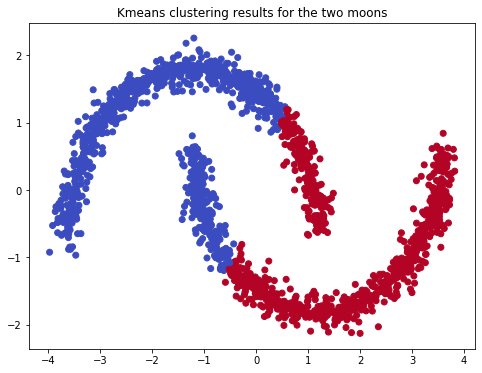

In [14]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=2).fit(X)
y_pred =  kmeans.labels_
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='coolwarm')
ax.set_title('Kmeans clustering results for the two moons')
plt.show()

K-means cannot find a good solution to this problem. Why?

*Your answer here* 
<br> K-means assumes to deal with spherical clusters and in fact the clustering process is based on distance to centroid. So it is not an optimal choice for this kind of dataset.

#### Question 7: Spectral clustering

As opposed to naive K-means, spectral clustering doesn't operate on the input space but on the eigenspace of the graph that represents the data. Implement spectral clustering. You can use 
[this tutorial](http://lasa.epfl.ch/teaching/lectures/ML_Phd/Notes/tutoSC.pdf).

In [15]:
class SpectralClustering():
    def __init__(self, n_classes: int, normalize: bool):
        self.n_classes = n_classes
        self.normalize = normalize
        self.laplacian = None
        self.e = None
        self.U = None
        self.clustering_method =  'normalized' if self.normalize else 'combinatorial' # To check --> KMeans for me
        
    def fit_predict(self, adjacency):
        """ Your code should be correct both for the combinatorial
            and the symmetric normalized spectral clustering.
            Return:
            y_pred (np.ndarray): cluster assignments.
        """
        # Compute Laplacian 
        self.laplacian = compute_laplacian(adjacency, normalize=self.normalize)
        # Eigenvalue decomposition
        self.e, self.U = spectral_decomposition(self.laplacian) 
        # keep only the k smallest and construct Uk
        self.e = self.e[:self.n_classes]
        self.U = self.U[:,:self.n_classes]        
        print("Connected components:", compute_number_connected_components(self.e, threshold=1e-12)) # lamb_n
        # Embedding in yi
        y = self.U#.transpose()
        if self.normalize:
            norm = np.sqrt(np.sum(self.U**2, axis=1, keepdims=True))
            y = y/norm          
        # Kmeans on yi to get centroids 
        kmean = KMeans(n_clusters=self.n_classes).fit(y)
        y_pred = kmean.labels_
        
        return y_pred

Connected components: 1


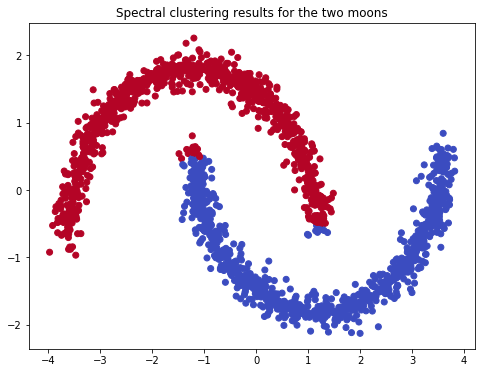

In [16]:
spectral_clustering = SpectralClustering(n_classes=2, normalize=True)
y_pred = spectral_clustering.fit_predict(adjacency)
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='coolwarm')
ax.set_title('Spectral clustering results for the two moons')
plt.show()

#### Question 8: On your dataset

Can you think of another 2D dataset in which k-means would badly perform, but spectral clustering would not?
Construct it!
For this question you can import any dataset of your choice, for example from `sklearn.datasets` or `pygsp.graphs`, but you can also get creative and define something of your own. First, create and plot the dataset.

In [17]:
def Smiley(N = 2000):
    """ return a 2D dataset representing a smiley with 4 classes (head, eyes, mouth) """
    # Head
    length = np.random.uniform(1.75, 2, size=int(2*N/5))
    angle = np.pi * np.random.uniform(0, 2, size=int(2*N/5))
    X_head = np.stack([length * np.cos(angle), length * np.sin(angle)], axis=1)
    Y_head = np.ones(X_head.shape[0])

    # eye 1
    length = np.random.uniform(0.1, 0.4, size=int(N/5))
    angle = np.pi * np.random.uniform(0, 2, size=int(N/5))
    X_eye1 = np.stack([-0.75 +length * np.cos(angle), 0.75 +length * np.sin(angle)], axis=1)
    Y_eye1 = 2*np.ones(X_eye1.shape[0])

    # eye 2
    length = np.random.uniform(0.1, 0.4, size=int(N/5))
    angle = np.pi * np.random.uniform(0, 2, size=int(N/5))
    X_eye2 = np.stack([0.75 +length * np.cos(angle), 0.75 +length * np.sin(angle)], axis=1)
    Y_eye2 = 3*np.ones(X_eye2.shape[0])

    # mouth
    length = np.random.uniform(1, 1.25, size=int(N/5))
    angle = np.pi * np.random.uniform(-0.15, -0.85, size=int(N/5))
    X_mouth = np.stack([length * np.cos(angle), -0.2 +length * np.sin(angle)], axis=1)
    Y_mouth = 4*np.ones(X_mouth.shape[0])

    X = np.concatenate([X_head, X_eye1, X_eye2, X_mouth], axis=0)
    Y = np.concatenate([Y_head, Y_eye1, Y_eye2, Y_mouth], axis=0)

    # Shuffle the data
    rdm_idx = np.arange(0,N,1)
    np.random.shuffle(rdm_idx)
    
    return X[rdm_idx, :], Y[rdm_idx]

In [18]:
X_s, Y_s = Smiley(2000)

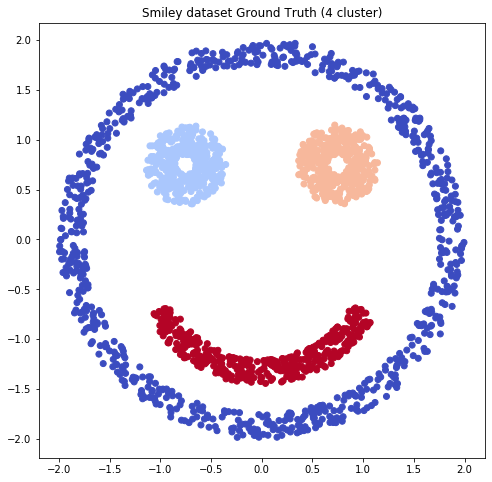

In [19]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.scatter(X_s[:, 0], X_s[:, 1], c=Y_s, cmap='coolwarm')
ax.set_title('Smiley dataset Ground Truth (4 cluster)')
plt.show()

Run K-means:

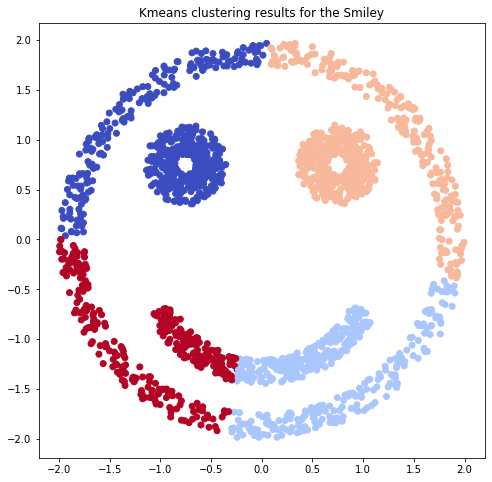

In [20]:
kmeans_s = KMeans(n_clusters=4).fit(X_s)
y_pred_s =  kmeans_s.labels_
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.scatter(X_s[:, 0], X_s[:, 1], c=y_pred_s, cmap='coolwarm')
ax.set_title('Kmeans clustering results for the Smiley')
plt.show()

Create the similarity graph, and run spectral clustering with both the combinatorial and normalized Laplacian matrices:

Combinatorial:
Connected components: 1

Normalized:
Connected components: 1


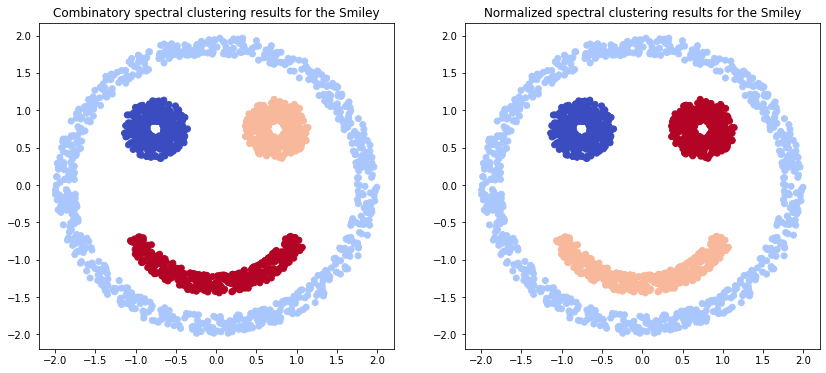

In [21]:
adjacency_s = epsilon_similarity_graph(X_s, sigma=0.4, epsilon=0.7)

print('Combinatorial:')
spectral_clustering_comb = SpectralClustering(n_classes=4, normalize=False)
y_pred_comb = spectral_clustering_comb.fit_predict(adjacency_s)

print('\nNormalized:')
spectral_clustering_norm = SpectralClustering(n_classes=4, normalize=True)
y_pred_norm = spectral_clustering_norm.fit_predict(adjacency_s)

fig, ax = plt.subplots(1,2,figsize=(14,6))
ax[0].scatter(X_s[:, 0], X_s[:, 1], c=y_pred_comb, cmap='coolwarm')
ax[0].set_title('Combinatory spectral clustering results for the Smiley')
ax[1].scatter(X_s[:, 0], X_s[:, 1], c=y_pred_norm, cmap='coolwarm')
ax[1].set_title('Normalized spectral clustering results for the Smiley')
plt.show()

## *Comment your results here*
<br> In this case as well K-means did not perform well, it makes cluster based to the closest distance to a centroid (in fact if we think about the smiley it divided in 4 quarter exactly), also because another assumption is that the equivalent portions of the subspace are allocated to each clusters. Both spectral techniques gave the correct classification but the sigma value was critical to select (?).

### Dimensionality Reduction with Laplacian Eigenmaps

Most datasets are very high-dimensional, which means it can be very hard to understand their geometry. Fortunately, there exists multiple  techniques that can help us to reduce the dimensionality of the data, and allow us to visualize it. 

In this part of the assignment we will use MNIST to compare these techniques. Indeed, without dimensionality reduction it would be very difficult to answer questions like: are the different digits clustered together in different areas of space? 

But first, let's load our dataset:

In [22]:
from utils import load_mnist

X_mnist, y_mnist = load_mnist()
classes = np.unique(y_mnist)

#### Question 9: Laplacian eigenmaps

Most dimensionality reduction algorithms are constructed such that some property of the dataset remains invariant in the lower dimensional representation. Before implementing laplacian eigenmaps, can you say what property of the data does this algorithm preserve?

Laplacian eigenmaps for spectral embedding preserves the locality of the initial manifold on average. Local information between samples are preserved after embedding.

Implement a function that uses Laplacian eigenmaps to do dimensionality reduction.

In [23]:
def laplacian_eigenmaps(X:np.ndarray, dim: int, sigma: float, epsilon: float, normalize: bool):
    """ Return:
        coords (n x dim array): new coordinates for the data points."""
    # compute adjencacy matrix on X (point in initial subspace)
    A = epsilon_similarity_graph(X, sigma, epsilon)
    # compute laplacian using function above 
    L = compute_laplacian(A, normalize)
    # eigenvalue decomposition of Ln
    e, U = spectral_decomposition(L)
    # number of vectors to remove
    to_remove = compute_number_connected_components(e, threshold=1e-12)
    print("Connected components:", to_remove)
    # remove zero eigenvalue
    e_embed = e[to_remove:dim+to_remove]
    U_embed = U[:,to_remove:dim+to_remove]
    y = U_embed
           
    return y

Use this function to visualize MNIST in 2D. Feel free to play with the different parameters.

In [24]:
dim = 2
X_mnist_embed2 = laplacian_eigenmaps(X_mnist, dim, 5000, 0.82, True)
print('Size embedded data :{}'.format(X_mnist_embed2.shape[1]))

Connected components: 1
Size embedded data :2


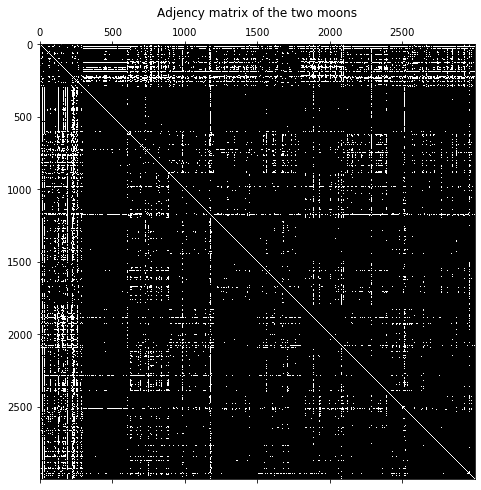

In [25]:
adjacency = epsilon_similarity_graph(X_mnist, sigma=5000, epsilon=0.82)
fig, ax = plt.subplots(1,1,figsize=(8,8))
ax.spy(adjacency)
ax.set_title('Adjency matrix of the two moons')
plt.show()

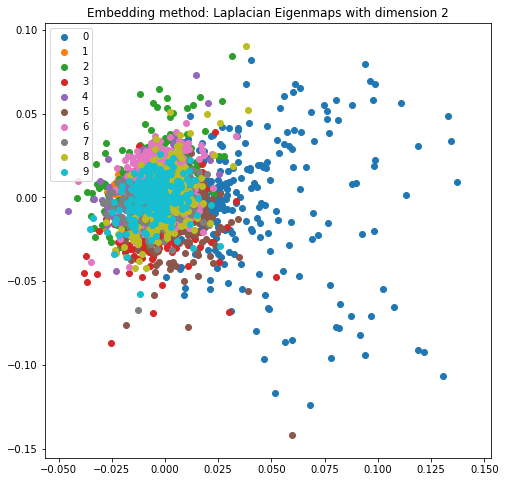

In [26]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
for i in classes:
    mask = y_mnist == i
    ax.scatter(X_mnist_embed2[mask,0], X_mnist_embed2[mask,1], label=i)
ax.legend(loc = 'upper left')
ax.set_title("Embedding method: Laplacian Eigenmaps with dimension {}".format(dim))
plt.show()

<font color='salmon'> 2 NEXT CELL TO BE REMOVED -> JUST FOR CHECKING<\font>

In [27]:
import sklearn
A = epsilon_similarity_graph(X_mnist, 5000, 0.82)
X_transformed = sklearn.manifold.spectral_embedding(A, n_components=2)

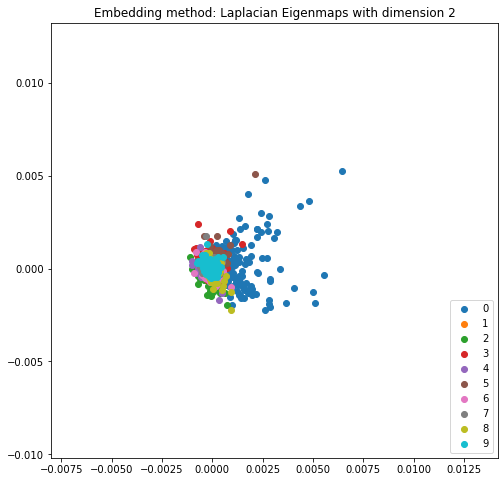

In [28]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
for i in classes:
    mask = y_mnist == i
    ax.scatter(X_transformed[mask,0], X_transformed[mask,1], label=i)
ax.legend(loc = 'lower right')
ax.set_title("Embedding method: Laplacian Eigenmaps with dimension {}".format(dim))
plt.show()

Visualize MNIST in 3D:

<font color='salmon'> NEXT CELL TO BE REMOVED -> JUST FOR CHECKING <\font>

(3000, 3)


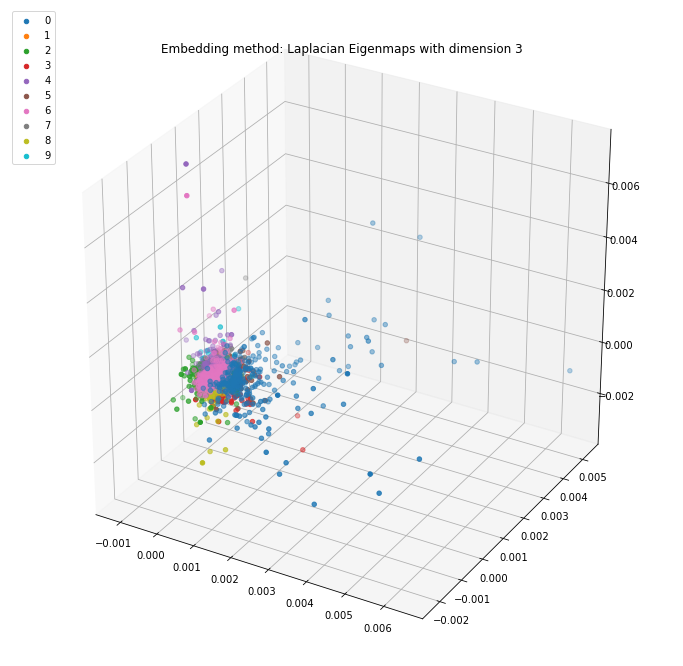

In [29]:
import sklearn
#embedding = sklearn.manifold.SpectralEmbedding(n_components=3, affinity='rbf')
#X_transformed = embedding.fit_transform(X_mnist_norm)
X_transformed = sklearn.manifold.spectral_embedding(A, n_components=3)
print(X_transformed.shape)
                                   
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111,projection= '3d')
for i in classes:
    mask = y_mnist == i
    ax.scatter(X_transformed[mask,0],X_transformed[mask,1],X_transformed[mask,2], zdir= 'z',label=i)
ax.legend(loc = 'upper left')
ax.set_title("Embedding method: Laplacian Eigenmaps with dimension {}".format(3))
plt.show()    

In [30]:
dim = 3
X_mnist_embed3 = laplacian_eigenmaps(X_mnist_norm,dim,5000,0.75,True)
print('Size embedded data :{}'.format(X_mnist_embed3.shape[1]))

NameError: name 'X_mnist_norm' is not defined

NameError: name 'X_mnist_embed3' is not defined

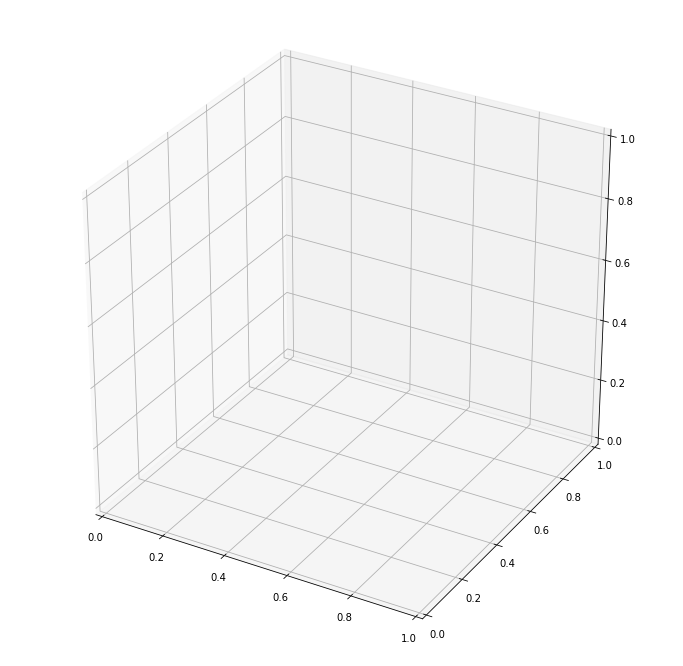

In [31]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111,projection= '3d')
for i in classes:
    mask = y_mnist == i
    ax.scatter(X_mnist_embed3[mask,0],X_mnist_embed3[mask,1],X_mnist_embed3[mask,2], zdir= 'x',label=i)
ax.legend(loc = 'upper left')
ax.set_title("Embedding method: Laplacian Eigenmaps with dimension {}".format(dim))
plt.show()

#### Question 10: Comparison with other methods  
We provide the visualization of MNIST with other methods:

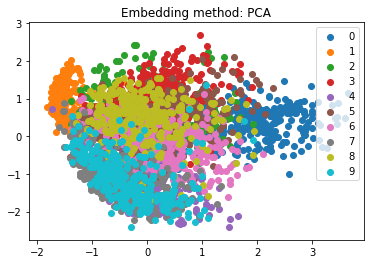

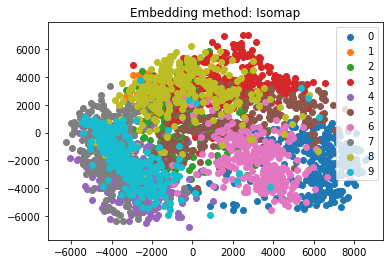

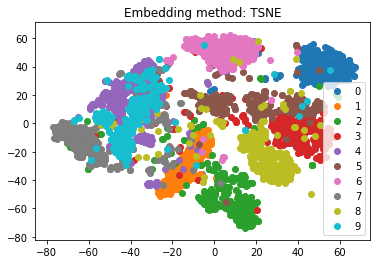

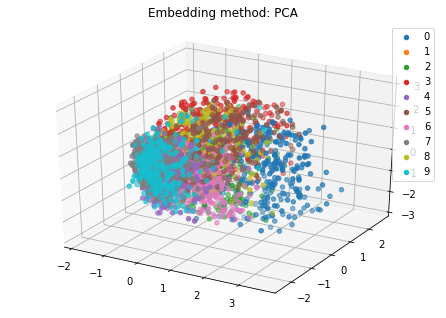

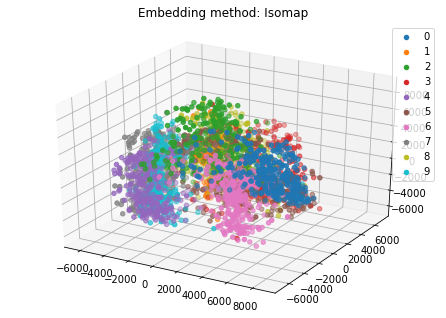

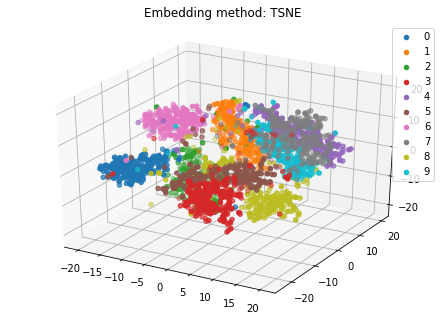

In [32]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap

# This cell can take a few minutes to run
run_this_cell = True

if run_this_cell:
    # In 2d
    embeddings = [PCA(n_components=2, copy=True, whiten=True, tol=1e-5),
                  Isomap(n_components=2, n_neighbors=5),
                  TSNE(n_components=2)]

    for embedding in embeddings:
        X_embedded = embedding.fit_transform(X_mnist)
        fig = plt.figure()
        for i in classes:
            mask = y_mnist == i
            plt.scatter(X_embedded[mask, 0], X_embedded[mask, 1], label=i)
        plt.legend()
        plt.title('Embedding method: '+ type(embedding).__name__)
        plt.show()

    # In 3d
    embeddings = [PCA(n_components=3, copy=True, whiten=True, tol=1e-5),
                  Isomap(n_components=3, n_neighbors=5),
                  TSNE(n_components=3)]

    for embedding in embeddings:
        X_embedded = embedding.fit_transform(X_mnist)
        fig = plt.figure()
        ax = Axes3D(fig)
        for i in classes:
            mask = y_mnist == i
            ax.scatter(X_embedded[mask, 0], X_embedded[mask, 1], X_embedded[mask, 2], label=i)
        ax.legend()
        ax.title.set_text('Embedding method: '+ type(embedding).__name__)
        plt.show()

In a few words, what are the principles guiding the design of each method? Compare their results.

PCA is the only linear method from those 3. It finds the best linear subspace on which to project the data. The subspace is found using the points themselves. The classical MDS method finds a linear subspace using the distances between points. The Isomap method is a generalisation of the classical MDS, it finds a subspace using local distances between points. This aims to preserve the geodesic distances between points during embedding. tSNE aims to keep neighbors close to each other after embedding. It uses a probability distribution to define similarities between points in the inital manifold and define points that should be kept based on this probability. <br>
Regarding results, tSNE seems to generate more dense and well defined clusters. Results between PCA and Isomaps, show that the preservation of the appromixation of geodesic distances enables a dimensionality reduction that enables to more or less distinguish the different classes. 

<a id='gsp'></a>
## Part II: Regularization on graphs with Graph Signal Processing

In this part of the assignment we are going to familiarize ourselves with the main concepts in Graph Signal Processing and regularization on graphs in general. From now on, you can only use the following libraries as well as the functions that you implemented in the previous parts.

In [33]:
import pandas as pd
import numpy as np
from pygsp.graphs import Bunny

In this exercise we will use a nearest-neighbor graph constructed from the Stanford Bunny point cloud included in the PyGSP library.

In [34]:
G = Bunny()
adjacency = np.asarray(G.W.todense())
n_nodes = adjacency.shape[0]

We will use the following function to plot our signals on this graph.

In [35]:
def plot_bunny(x=None, title='', vlim=[-0.03, 0.03]):
    fig = plt.gcf()
    ax = plt.gca()
    if not isinstance(ax, Axes3D):
        ax = plt.subplot(111, projection='3d')
    if x is not None:
        x = np.squeeze(x)

    p = ax.scatter(G.coords[:,0], G.coords[:,1], G.coords[:,2], c=x, marker='o',
                   s=5, cmap='RdBu_r', vmin=vlim[0], vmax=vlim[1])
    ax.view_init(elev=-90, azim=90)
    ax.dist = 7
    ax.set_axis_off()
    ax.set_title(title)
    if x is not None:
        fig.colorbar(p)

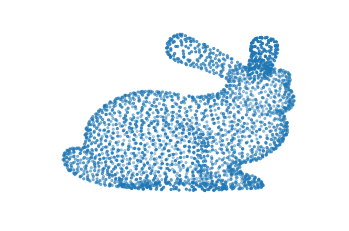

In [36]:
plt.subplot(111, projection='3d')
plot_bunny()

#### Question 11: Graph frequencies

Let us start by constructing the normalized graph laplacians from the adjacency matrix and find its spectral decomposition.

In [37]:
laplacian = compute_laplacian(adjacency, normalize=True)
lam, U = spectral_decomposition(laplacian)

Plot the eigenvalues.

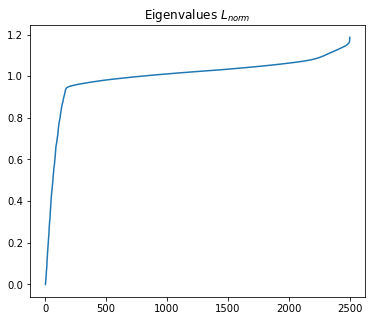

In [38]:
plt.figure(figsize=(6, 5))
plt.plot(lam)
plt.title('Eigenvalues $L_{norm}$')
plt.show()

To make things more clear we will plot some of its eigenvectors (0, 1, 3, 10, 100) as signals on the bunny graph.

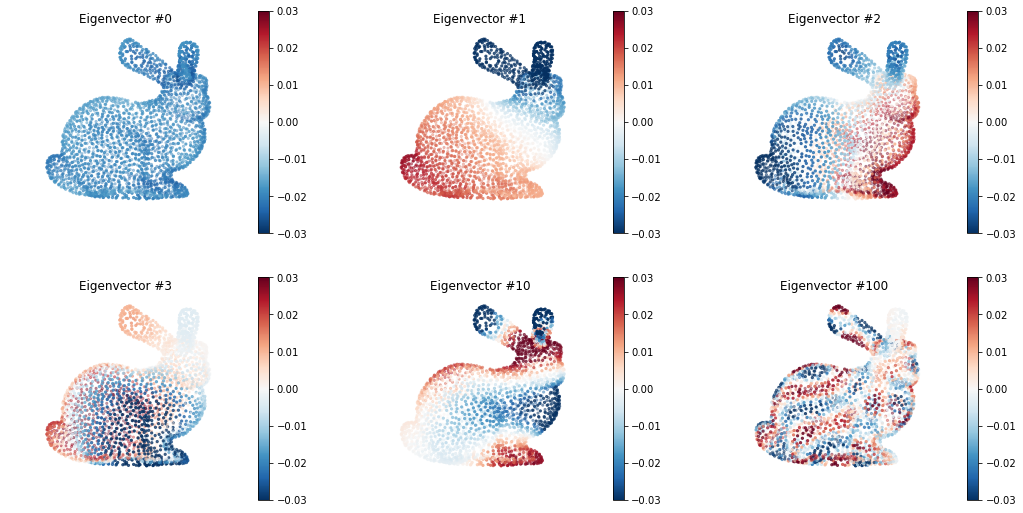

In [39]:
plt.figure(figsize=(18, 9))
plt.subplot(231, projection='3d')
plot_bunny(x=U[:,0], title='Eigenvector #0')
plt.subplot(232, projection='3d')
plot_bunny(x=U[:,1], title='Eigenvector #1')
plt.subplot(233, projection='3d')
plot_bunny(x=U[:,2], title='Eigenvector #2')

plt.subplot(234, projection='3d')
plot_bunny(x=U[:,3], title='Eigenvector #3')
plt.subplot(235, projection='3d')
plot_bunny(x=U[:,10], title='Eigenvector #10')
plt.subplot(236, projection='3d')
plot_bunny(x=U[:,100], title='Eigenvector #100')

What can you say in terms of the variation (smoothness) of these signals? How can the smoothness of a signal be measured?

The smoothness decreases with the increase of the value of the associated eigenvalue. Hence by ranking the eigenvector from smallest to largest eigenvalue, the last vectors are the less smooth. This is what we observe in the patterns above. The eigenvalue is hence a good metric to identify the smoothness of a signal.

#### Question 12: Graph Fourier Transform

Create a function to compute the Graph Fourier Transform (GFT) of a graph signal and its inverse.
**Note**: You can assume that you have internal access to the eigendecomposition (`U` and `lam`) of the laplacian.

In [40]:
def GFT(signal: np.ndarray): 
    """ Return:
        Graph Fourier Transform of a signal."""
    fourier_coefficients = U.T@x
    return fourier_coefficients

def iGFT(fourier_coefficients: np.ndarray):
    """ Return:
        Original signal."""
    signal = U*fourier_coefficients
    return signal

Now, let's create a graph signal:

/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


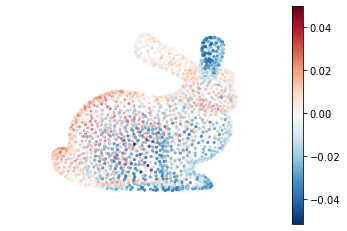

In [41]:
x = G.coords[:, 0] + G.coords[:, 1] + 3 * G.coords[:, 2]
x /= np.linalg.norm(x) 

noise = np.random.randn(n_nodes)
noise /= np.linalg.norm(noise) 

x_noisy = x + 0.3*noise

plot_bunny(x_noisy, vlim=[min(x_noisy), max(x_noisy)])

and plot its graph spectrum:

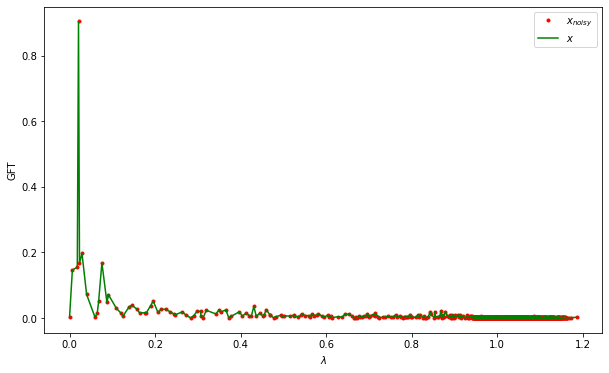

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(lam, np.abs(GFT(x_noisy)), 'r.') 
plt.plot(lam, np.abs(GFT(x)), 'g-')
plt.xlabel('$\lambda$')
plt.ylabel('GFT')
plt.legend(['$x_{noisy}$', '$x$'])

#### Question 13: Graph filters

We will try to extract the signal from the noise using graph filters. Let us start by creating three ideal graph filters.

In [43]:
ideal_lp = np.ones((n_nodes,))
ideal_bp = np.ones((n_nodes,))
ideal_hp = np.ones((n_nodes,))

ideal_lp[lam >= 0.1] = 0  # Low-pass filter with cut-off at lambda=0.1
ideal_bp[lam < 0.1] = 0  # Band-pass filter with cut-offs at lambda=0.1 and lambda=0.5
ideal_bp[lam > 0.5] = 0
ideal_hp[lam <= 1] = 0  # High-pass filter with cut-off at lambda=1

Additionally, create the ideal graph filter that implements the solution of Tikhonov regularization.

In [44]:
alpha = 0.99 / np.max(lam)

ideal_tk = 1/(1+alpha*lam)

Let's plot the spectral responses:

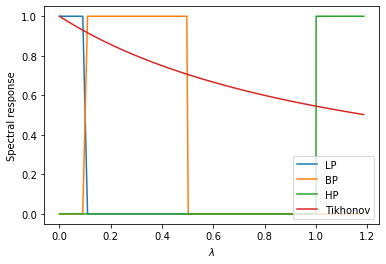

In [45]:
plt.plot(lam, ideal_lp, '-', label='LP')
plt.plot(lam, ideal_bp, '-', label='BP')
plt.plot(lam, ideal_hp, '-', label='HP')
plt.plot(lam, ideal_tk, '-', label='Tikhonov')
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')
plt.legend(loc='lower right')

Create a function to filter a signal given an ideal graph filter

In [46]:
def ideal_graph_filter(x: np.ndarray, spectral_response: np.ndarray):
    """Return a filtered signal."""
    fitered_signal = U@np.diag(spectral_response)@U.T@x
    return fitered_signal

Let us visualize the results:

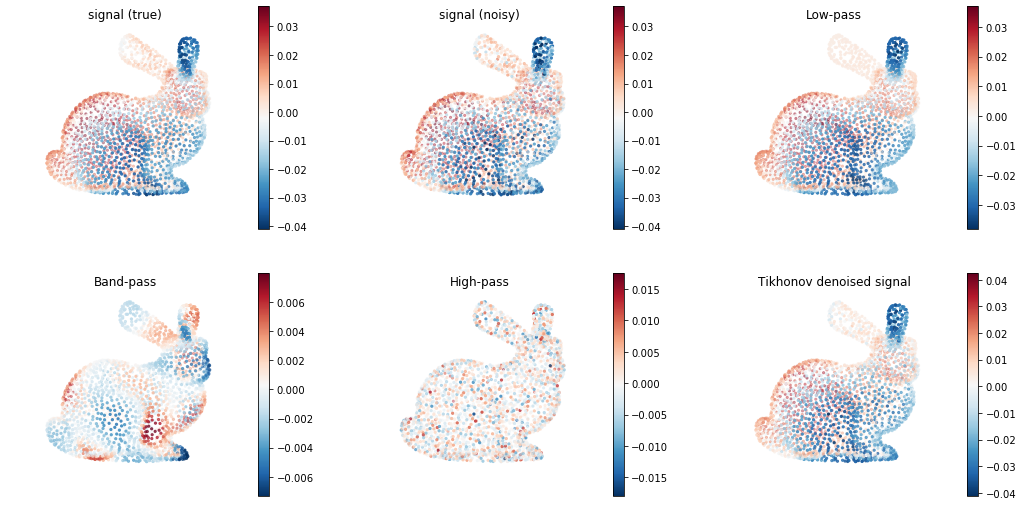

In [47]:
x_lp = ideal_graph_filter(x_noisy,ideal_lp)
x_bp = ideal_graph_filter(x_noisy,ideal_bp)
x_hp = ideal_graph_filter(x_noisy,ideal_hp)
x_tk = ideal_graph_filter(x_noisy,ideal_tk)

plt.figure(figsize=(18, 9))
plt.subplot(231, projection='3d')
plot_bunny(x=x, title='signal (true)', vlim=[min(x), max(x)])
plt.subplot(232, projection='3d')
plot_bunny(x=x_noisy, title='signal (noisy)', vlim=[min(x), max(x)])
plt.subplot(233, projection='3d')
plot_bunny(x=x_lp, title='Low-pass', vlim=[min(x_lp), max(x_lp)])
plt.subplot(234, projection='3d')
plot_bunny(x=x_bp, title='Band-pass', vlim=[min(x_bp), max(x_bp)])
plt.subplot(235, projection='3d')
plot_bunny(x=x_hp, title='High-pass', vlim=[min(x_hp), max(x_hp)])
plt.subplot(236, projection='3d')
plot_bunny(x=x_tk, title='Tikhonov denoised signal', vlim=[min(x_tk), max(x_tk)])

How would you link to the observations you made before about the spectral decomposition of the laplacian?
Also, judging from the results, what type of model prior do you think Tikhonov regularization enforces?

*Your answer here*
<br> Tikhonov regularization enforces gaussian prior (L2 norm and low-pass behaviour)??

#### Question 14: Polynomial graph filters

We have seen how we can use the GFT to define different filters that enhance or reduce certain frequency bands. However, to do so, we require an explicit eigendecomposition of the graph laplacian, which has a cost $O(n^3)$. For very large graphs this is very intense computationally. We will now see how we can obtain similar results by filtering the signals directly without resorting to an eigendecomposition.

The key idea is to use a polynomial of the graph laplacian to define a graph filter, i.e., $g(L)x=\sum_{k=1}^K \alpha_k L^k x$, and use the fact that the powers of a diagonalizable matrix can be written in terms of powers of its eigenvalues. This is
$$
L^k=(U\Lambda U^T)^k=U\Lambda^k U^T = U\begin{bmatrix}
(\lambda_0)^k &\dots & 0\\
\vdots & \ddots & \vdots\\
0 & \dots & (\lambda_N)^k
\end{bmatrix} U^T.
$$

This means that a polynomial of the graph laplacian acts independently on each eigenvalue of the graph, and has a frequency spectrum of
$$g(\lambda)=\sum_{k=1}^K \alpha_k \lambda^k.$$
Hence,
$$g(L)x=\sum_{k=1}^K \alpha_k L^k x=\sum_{k=1}^K \alpha_k U\Lambda^k U^T x=U \left(\sum_{k=1}^K \alpha_k\Lambda^k \right)U^T x=\operatorname{iGFT}\left(g(\Lambda)\operatorname{GFT}(x)\right).$$

With these ingredients, we have reduced the design of graph filters in the vertex domain to a regression task that approximates a given spectral response by a polynomial. There are multiple ways to do this, but in this assignment we will implement a very simple strategy based on [least-squares regression](https://en.wikipedia.org/wiki/Polynomial_regression#Matrix_form_and_calculation_of_estimates).

Implement a function to find the coefficients of a polynomial that approximates a given ideal filter.
**Hint:** `np.vander` and `np.linalg.lstsq`.

In [61]:
def fit_polynomial(lam: np.ndarray, order: int, spectral_response: np.ndarray):
    """ Return an array of polynomial coefficients of length 'order'."""
    V = np.vander(lam,order,increasing=True)
    polynomial_coefficients = np.linalg.lstsq(V.T@V,V.T@spectral_response)
    return polynomial_coefficients[0]

Implement a function to compute the frequency response of that filter.

In [62]:
def polynomial_graph_filter_response(coeff: np.array, lam: np.ndarray):
    """ Return an array of the same shape as lam.
        response[i] is the spectral response at frequency lam[i]. """
    V = np.vander(lam,coeff.shape[0],increasing=True)
    response = V@coeff
    return response

Let us fit the Tikhonov ideal filter with several polynomials of different order.

/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


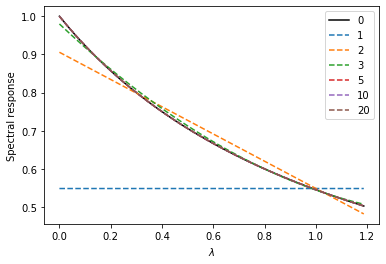

In [64]:
plt.plot(lam, ideal_tk,'k')
orders = [1, 2, 3, 5, 10, 20]
for order in orders:    
    coeff_tk = fit_polynomial(lam, order, ideal_tk)
    plt.plot(lam, polynomial_graph_filter_response(coeff_tk, lam),'--')

plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')
plt.legend([0, 1, 2, 3, 5, 10, 20])

So far, we have only defined a way to compute the coefficients of our laplacian polynomial. Let us now compute our graph filter.

In [65]:
def polynomial_graph_filter(coeff: np.array, laplacian: np.ndarray):
    """ Return the laplacian polynomial with coefficients 'coeff'. """
    laplacian_polynomial = np.zeros(laplacian.shape)
    for i in range(coeff.shape[0]):
        laplacian_polynomial = laplacian_polynomial + coeff[i]*np.linalg.matrix_power(laplacian,i)
    return laplacian_polynomial

Based on the previous plot, choose a filter order that achieves (in your opinion) a good tradeoff in terms of computational complexity and response accuracy.
<br> Degree 5 is the fist polynomyal to give a almost perfect approximation and going higher doesn't make sense (higher complexity)

In [66]:
order =  5
coeff_tk = fit_polynomial(lam, order, ideal_tk)
g_tk = polynomial_graph_filter(coeff_tk, laplacian)

/anaconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


#### Question 15: ARMA filter

As you have seen in class, polynomial graph filters are only one of the ways in which you can approximate ideal graph filters. 
In this sense, ARMA filters are a natural way to implement Tikhonov denoising on graphs.
Let us recall the general solution of the Tikhonov regularized denoising problem 

$$y=(I+\alpha L)^{-1}x. $$

With a little bit of algebra manipulation we can rewrite this expression as
$$
    y = -\alpha L y + x,
$$
from which we can derive the iterative algorithm
$$
    y_k = -\alpha L y_{k-1} + x\qquad k=1,2,\dots
$$
which is guaranteed to converge as long as $\alpha \lambda_{max} < 1$.

Implement the ARMA version of Tikhonov regularization.

In [67]:
def arma_tikhonov(x: np.ndarray, laplacian: np.ndarray, alpha: float, max_iter=50):
    """ Return an array of the same shape as x."""
    y = x
    n = 0;
    while (n < max_iter):
        n = n + 1
        y = x - alpha*laplacian@y
    return y

Filter the previous noisy graph signal with the polynomial and ARMA approximations of the ideal Tikhonov filter.

In [68]:
x_tk_polynomial = g_tk@x_noisy # not sure !!!
x_tk_arma = arma_tikhonov(x_noisy, laplacian, alpha)

Let us compare with the previous version.

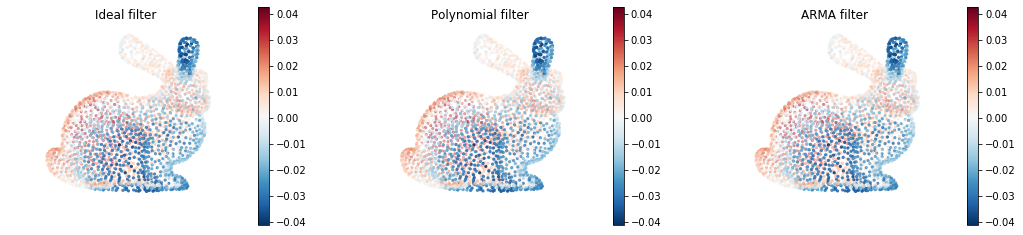

In [69]:
plt.figure(figsize=(18, 4))
plt.subplot(131, projection='3d')
plot_bunny(x_tk, title='Ideal filter', vlim=[min(x_tk), max(x_tk)])
plt.subplot(132, projection='3d')
plot_bunny(x_tk_polynomial, title='Polynomial filter', vlim=[min(x_tk), max(x_tk)])
plt.subplot(133, projection='3d')
plot_bunny(x_tk_arma, title='ARMA filter', vlim=[min(x_tk), max(x_tk)])

<a id='ml'></a>
## Part III: Machine Learning on Graphs

So far, we have only played with toy examples. Let us see the use of these tools in practice! In particular, let us see how we can use some graph filters to construct features to feed a classifier. For this part of the assignment we will import some extra packages.

In [ ]:
import time

import networkx as nx
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl.function as fn
from dgl import DGLGraph
from dgl.data.citation_graph import load_cora

np.random.seed(0)
torch.manual_seed(1)

We will use the CORA dataset and the citation graph that we created in Assignment 1. However, to simplify the next tasks we will directly use the preprocessed version of this dataset contained within the Deep Graph Library (DGL).

In this assignment, we will interpret CORA's features as multidimensional graph signals living on the citation graph.
Our task is to design a classifier that uses these features and the geometry of the graph can identify the type of paper each node represents.

The goal of this exercise is to do semi-supervised learning on graphs.
We assume that we know to which scientific field a small subset of the papers belongs (the ones contained in `train_mask`).
The goal is to predict to which field the other papers belong, using both the citation graph and the bag-of-word representation of each paper.

In [ ]:
cora = load_cora()

features = torch.FloatTensor(cora.features)    # Feature vector for each paper
labels = torch.LongTensor(cora.labels)         # The field to which each paper belongs

train_mask = torch.BoolTensor(cora.train_mask) # Mask of nodes selected for training
val_mask = torch.BoolTensor(cora.val_mask)     # Mask of nodes selected for validation
test_mask = torch.BoolTensor(cora.test_mask)   # Mask of nodes selected for testing

in_feats = features.shape[1]
n_classes = cora.num_labels
n_edges = cora.graph.number_of_edges()

graph = cora.graph
adjacency = np.asarray(nx.to_numpy_matrix(graph))
n_nodes = adjacency.shape[0]

For this exercise we will use the normalized laplacian.

In [ ]:
laplacian = compute_laplacian(adjacency, normalize=True)
lam, U = spectral_decomposition(laplacian)
lam_max = np.max(lam)

#### Question 16: Logistic regression

The simplest classification method consists in ignoring the citation graph and trying to classify the papers using only the features.
In this case, the problem is viewed as a standard classification task.
To train our classifier we will select a few nodes in our graph for training and fit a [logistic regression classifier](https://en.wikipedia.org/wiki/Logistic_regression) on them.
To avoid overfitting to the test set when we do hyperparameter tuning, we will also select a validation set.
And finally, we will test our classifier on the rest of the nodes.
**Hint:** use `sklearn.linear_model.LogisticRegression`.

In [ ]:
train_features = features[train_mask]
train_labels = labels[train_mask]
val_features = features[val_mask]
val_labels = labels[val_mask]
test_features = features[test_mask]
test_labels = labels[test_mask]

In [ ]:
# Fit a logistic regression model
# Your code here

In [ ]:
train_acc =  # Your code here
val_acc =  # Your code here
test_acc =  # Your code here

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

#### Question 17: Handcrafted graph filters

That's not a bad start! Now, let's try to improve a bit the results by taking into account the graph structure using tools from GSP. For this purpose, we will design a handcrafted filter that will be used to denoise the signal, before feeding it to a logistic regression.

However, before we start, what hypothesis can you make on the spectral properties of the denoised signal?

*Your answer here*

Based on this prior, design an ideal filter response that you believe could enhance important features of the graph. 

**Note:** you just need to design one graph filter that we will apply to all features. Don't design a different filter for each feature. 

**Note:** finding the right filter can be very challenging, don't worry if you can't find it. Just make sure you experiment with a few configurations and parameters.

In [ ]:
ideal_filter =  # Store your spectral response here

Choose a filter order to approximate your filter using laplacian polynomials.

In [ ]:
order =  # Your code here

coeff = fit_polynomial(lam, order, ideal_filter)
graph_filter = polynomial_graph_filter(coeff, laplacian)

Let's plot the frequency response of your spectral template and its polynomial approximation.

In [ ]:
plt.plot(lam, ideal_filter)
plt.plot(lam, polynomial_graph_filter_response(coeff, lam))
plt.legend(['Ideal', 'Polynomial'])
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response')

Now, let's create the new features.

In [ ]:
filtered_features = graph_filter @ features.numpy()

train_features = filtered_features[train_mask,:]
train_labels = labels[train_mask]

val_features = filtered_features[val_mask,:]
val_labels = labels[val_mask]

test_features = filtered_features[test_mask,:]
test_labels = labels[test_mask]

Train another logistic regression classifier on the new features. Remember to play with the regularization parameters to achieve a well performing model.

In [ ]:
# Your code here

Evaluate your model.

In [ ]:
train_acc =  # Your code here
val_acc =  # Your code here
test_acc =  # Your code here

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

#### Question 18: Graph convolutional networks

By now, you will probably have seen that it is challenging to find the right combination of spectral response, filter parameters and regularization method. And in most cases, this is a painstaking job. Wouldn't it be great to automate these tasks?

Fortunately, this is possible if we use the right tools! Specifically, we will see that Graph Convolutional Networks are a great framework to automatize the feature extraction method.

In this exercise, we will follow the same classification pipeline as above, but instead of hand-crafting our filter we will let `PyTorch` find the coefficients for us using gradient descent.

In this section, most of the code is already written. Try to understand it and to play with some parameters. It may be useful if you want to solve some learning task in your project.

We start by constructing a `LaplacianPolynomial` model in `DGL`. It computes the function: $f(X) = \sum_{i=1}^{k} \alpha_i L^i X \theta$ where the trainable parameters are the coefficients $\alpha_i$ and the matrix $\theta$. This function can be interpreted as a filtering of $X$ by $\sum_{i=1}^{k} \alpha_i L^i$ followed by a linear layer.

In [ ]:
class LaplacianPolynomial(nn.Module):
    def __init__(self,
                 in_feats: int,
                 out_feats: int,
                 k: int,
                 dropout_prob: float,
                 norm=True):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._k = k
        self._norm = norm
        # Contains the weights learned by the Laplacian polynomial
        self.pol_weights = nn.Parameter(torch.Tensor(self._k + 1))
        # Contains the weights learned by the logistic regression (without bias)
        self.logr_weights = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        torch.manual_seed(0)
        torch.nn.init.xavier_uniform_(self.logr_weights, gain=0.01)
        torch.nn.init.normal_(self.pol_weights, mean=0.0, std=1e-3)

    def forward(self, graph, feat):
        r"""Compute graph convolution.

        Notes
        -----
        * Input shape: :math:`(N, *, \text{in_feats})` where * means any number of additional
          dimensions, :math:`N` is the number of nodes.
        * Output shape: :math:`(N, *, \text{out_feats})` where all but the last dimension are
          the same shape as the input.

        Parameters
        ----------
        graph (DGLGraph) : The graph.
        feat (torch.Tensor): The input feature

        Returns
        -------
        (torch.Tensor) The output feature
        """
        feat = self.dropout(feat)
        graph = graph.local_var()
        
        # D^(-1/2)
        norm = torch.pow(graph.in_degrees().float().clamp(min=1), -0.5)
        shp = norm.shape + (1,) * (feat.dim() - 1)
        norm = torch.reshape(norm, shp)

        # mult W first to reduce the feature size for aggregation.
        feat = torch.matmul(feat, self.logr_weights)

        result = self.pol_weights[0] * feat.clone()

        for i in range(1, self._k + 1):
            old_feat = feat.clone()
            if self._norm:
                feat = feat * norm
            graph.ndata['h'] = feat
            # Feat is not modified in place
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h'))
            if self._norm:
                graph.ndata['h'] = graph.ndata['h'] * norm

            feat = old_feat - graph.ndata['h']
            result += self.pol_weights[i] * feat

        return result

    def extra_repr(self):
        """Set the extra representation of the module,
        which will come into effect when printing the model.
        """
        summary = 'in={_in_feats}, out={_out_feats}'
        summary += ', normalization={_norm}'
        return summary.format(**self.__dict__)

Once we have are model ready we just need to create a function that performs one step of our training loop, and another one that evaluates our model.

In [ ]:
def train(model, g, features, labels, loss_fcn, train_mask, optimizer):
    model.train()  # Activate dropout
    
    logits = model(g, features)
    loss = loss_fcn(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

def evaluate(model, g, features, labels, mask):
    model.eval()  # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask]  # only compute the evaluation set
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

Choose the training parameters.

In [ ]:
pol_order = 3
lr = 0.2
weight_decay = 5e-6
n_epochs = 1000
p_dropout = 0.8

And train the classifier end to end.

In [ ]:
graph = DGLGraph(cora.graph)

model = LaplacianPolynomial(in_feats, n_classes, pol_order, p_dropout)

loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)

dur = []
for epoch in range(n_epochs):
    if epoch >= 3:
        t0 = time.time()
    loss = train(model, graph, features, labels, loss_fcn, train_mask, optimizer)

    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(model, graph, features, labels, val_mask)
    print("Epoch {:05d} | Time(s) {:.4f} | Train Loss {:.4f} | Val Accuracy {:.4f}". format(
            epoch, np.mean(dur), loss.item(), acc))

print()
acc = evaluate(model, graph, features, labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))

Trained this way our GCN based on polynomials of the laplacian is a black box. Fortunately, however, the only difference between this shallow model and our previous classifier is the way we chose the filter coefficients.

Let's see what the network learned.
Print the coefficients of the learned filter.

In [ ]:
coeff_gcn =  # Your code here
print(coeff_gcn)

To interpret the model we can plot the frequency response of the learned filter.

In [ ]:
plt.semilogy(lam, np.abs(polynomial_graph_filter_response(coeff_gcn, lam)))
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response (db)')

#### Question 19

As we said, the whole classification pipeline of the previous exercise is identical to the one we tried before: Graph filtering + Logistic regression. The only difference lies in the way we chose the filter coefficients. First we were choosing them manually, and now, we let `PyTorch` find them for us. However, if everything is correct we should be able to use this filter to construct new hand-crafted features and train a logistic regression model that achieves good accuracy on the training set. Let's do that!

Use the learned coefficients to train a new feature extractor:

In [ ]:
graph_gcn_filter =  # Your code here

Let's extract the new features by filtering the data:

In [ ]:
features_gcn = graph_gcn_filter @ features.numpy()

train_features_gcn = features_gcn[train_mask,:]
train_labels = labels[train_mask]
val_features_gcn = features_gcn[val_mask,:]
val_labels = labels[val_mask]
test_features_gcn = features_gcn[test_mask,:]
test_labels = labels[test_mask]

Train a logistic regression on these features:

In [ ]:
# Your code here

Finally, let's evaluate this model:

In [ ]:
train_acc =  # Your code here
val_acc =  # Your code here
test_acc =  # Your code here

print('Train accuracy {:.4f} | Validation accuracy {:.4f} | Test accuracy {:.4f}'.format(train_acc, val_acc, test_acc))

The performance of this model may not be exactly the same as the one obtained with Pytorch. What are the differences in the training procedure that can explain this gap?

*Your answer here*